In [13]:
# based on https://medium.com/@alf.19x/how-to-build-your-own-expected-goals-xg-model-2bd186dccdf7

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer import Sbopen

pd.set_option('display.max_columns', 500)

In [2]:
parser = Sbopen()

In [5]:
df_match = parser.match(competition_id=43, season_id=106)

In [7]:
# iterate through all matches to get the events data
df_matches = {}
for i, id in enumerate(df_match['match_id']):
  df_matches[id] = {}
  df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)

In [8]:
# example events data, filtered to shots only
df_matches[3857288]['event'][df_matches[3857288]['event']['type_name'] == 'Shot'].head()

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,outcome_id,outcome_name,counterpress,aerial_won,ball_recovery_recovery_failure,pass_switch,out,dribble_nutmeg,pass_cross,shot_statsbomb_xg,shot_first_time,technique_id,technique_name,goalkeeper_position_id,goalkeeper_position_name,off_camera,pass_cut_back,injury_stoppage_in_chain,pass_deflected,block_deflection,pass_assisted_shot_id,pass_shot_assist,end_z,shot_key_pass_id,foul_committed_offensive,foul_committed_card_id,foul_committed_card_name,foul_won_defensive,foul_committed_advantage,foul_won_advantage,substitution_replacement_id,substitution_replacement_name,dribble_overrun
225,f7f89232-029c-46d3-9b33-6171761da364,226,1,00:05:35,5,35,15,0.037121,3857288,16,Shot,792,Australia,3,From Free Kick,792,Australia,None,28370.0,Fran Karačić,2.0,Right Back,NaN,NaN,NaN,NaN,NaN,NaN,91.8,41.1,40.0,Right Foot,87.0,Open Play,90.9,41.2,1.0,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015131,True,95.0,Volley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,079ee5e7-8f88-419b-874f-08f5f6d45c07,816,1,00:20:20,20,20,43,1.158633,3857288,16,Shot,777,Tunisia,4,From Throw In,777,Tunisia,None,9236.0,Mohamed Dräger,7.0,Right Wing Back,NaN,NaN,NaN,NaN,NaN,NaN,120.0,40.4,40.0,Right Foot,87.0,Open Play,92.0,42.5,NaN,98.0,Off T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029704,NaN,93.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,7b76477e-90f5-4ef8-a2e9-538a3500400b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,3af59ce2-13dd-4ef4-b999-35444cb60d7c,856,1,00:22:50,22,50,47,1.104271,3857288,16,Shot,792,Australia,4,From Throw In,792,Australia,None,33492.0,Mitchell Thomas Duke,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,120.0,43.6,37.0,Head,87.0,Open Play,110.1,32.5,NaN,97.0,Goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044595,NaN,93.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,787614d6-21dd-40c6-9fd7-be27b59bdc71,879,1,00:26:06,26,6,50,0.095529,3857288,16,Shot,792,Australia,3,From Free Kick,792,Australia,None,33492.0,Mitchell Thomas Duke,22.0,Right Center Forward,NaN,NaN,NaN,NaN,NaN,NaN,111.4,34.8,37.0,Head,87.0,Open Play,110.7,34.3,NaN,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039484,NaN,93.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,959fe1f8-14c4-4f1f-be78-7642c520ee21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1072,0053d038-426b-4756-b8e3-67355127786c,1073,1,00:33:45,33,45,64,0.629841,3857288,16,Shot,792,Australia,2,From Corner,792,Australia,None,5490.0,Jackson Irvine,9.0,Right Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,120.0,47.2,40.0,Right Foot,87.0,Open Play,114.3,48.2,NaN,98.0,Off T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075431,True,89.0,Backheel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,e1ac1a22-6c63-4700-a85c-3b8328d9de74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_matches[3857288]['event'].shape

(3360, 70)

In [15]:
# types of shot play
df_matches[3869321]['event'][df_matches[3869321]['event']['type_name'] == 'Shot']['sub_type_name'].unique()

array(['Open Play', 'Free Kick', 'Penalty'], dtype=object)

In [17]:
# we'll take the location, outcome, and also the xG by Statsbomb to compare it to our model later
df_shot = pd.DataFrame(columns=['x', 'y', 'outcome_name', 'shot_statsbomb_xg'])

for id in df_match['match_id']:
  # we take the period <= 4 because statsbomb also record penalty shots in the penalty shoot-out stage, we won't be using those shots
  # for our first model, we'll only take open play shots because penalty shots tend to have way higher goal probability
  # we'll use the other shots scenario in our next model
  mask_shot = (df_matches[id]['event'].type_name == 'Shot') & (df_matches[id]['event'].period	<= 4) & (df_matches[id]['event'].sub_type_name	== 'Open Play')
  shots_temp = df_matches[id]['event'].loc[mask_shot, ['x', 'y', 'outcome_name', 'shot_statsbomb_xg']]
  df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)

In [19]:
df_shot.head()

,x,y,outcome_name,shot_statsbomb_xg
0,96.0,38.8,Blocked,0.036566
1,113.1,40.7,Saved,0.353289
2,103.8,41.9,Saved,0.069527
3,112.2,36.8,Off T,0.081609
4,97.8,51.5,Post,0.030002


In [21]:
len(df_shot)

1382

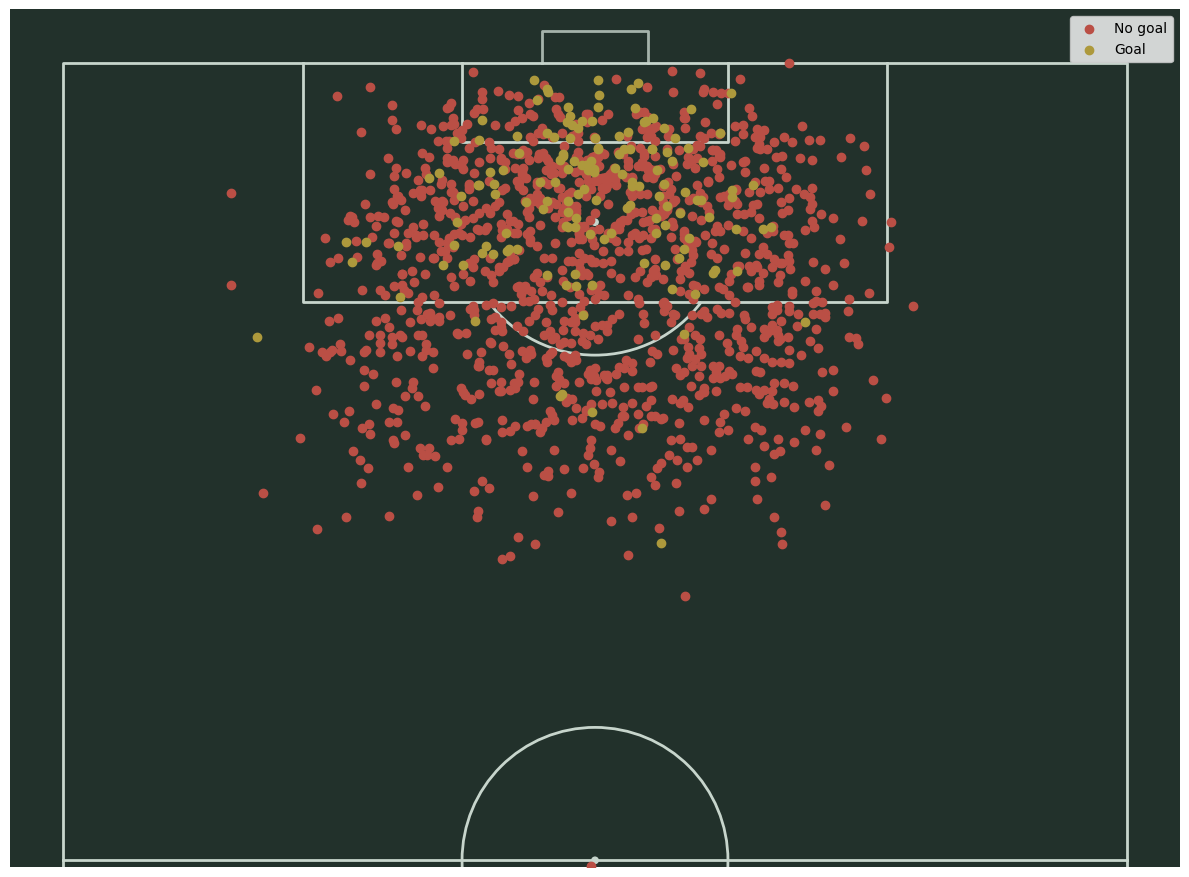

In [23]:
# visualizing shots

# filter goals / non-shot goals
df_goals = df_shot[df_shot.outcome_name == 'Goal'].copy()
df_non_goal_shots = df_shot[df_shot.outcome_name != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='#ba4f45',
                    marker='o',
                    ax=ax, label="No goal")

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='#ad993c',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
plt.show()

In [25]:
import math

def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(math.radians(abs(np.degrees(angle))))

def calculate_distance(x, y):
  x_dist = 120-x
  y_dist = 0
  if (y<36):
    y_dist = 36-y
  elif (y>44):
    y_dist = y-44
  return math.sqrt(x_dist**2 + y_dist**2)

In [27]:
df_shot['angle'] = df_shot.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance'] = df_shot.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)

In [28]:
# we'll create new column to define goal or not
df_shot['goal'] = df_shot.apply(lambda row:1 if row['outcome_name']=='Goal' else 0, axis=1)

In [29]:
df_shot.head()

,x,y,outcome_name,shot_statsbomb_xg,angle,distance,goal
0,96.0,38.8,Blocked,0.036566,0.329510,24.00000,0
1,113.1,40.7,Saved,0.353289,1.044075,6.90000,0
2,103.8,41.9,Saved,0.069527,0.478177,16.20000,0
3,112.2,36.8,Off T,0.081609,0.847626,7.80000,0
4,97.8,51.5,Post,0.030002,0.283717,23.43267,0


In [30]:
df_goals_only = df_shot[df_shot['goal'] == 1]

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Przygotowanie danych
df_shot = df_shot.dropna()  # Usuwamy brakujące wartości
X = df_shot[['distance', 'angle']]  # Zmienne wejściowe
y = df_shot['goal']  # Cel (1 - gol, 0 - nie)

# 2. Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Trenowanie modelu regresji logistycznej
model = LogisticRegression()
model.fit(X_train, y_train)

# 4. Predykcja xG
df_shot['xG_model'] = model.predict_proba(X)[:, 1]

# 5. Ewaluacja modelu
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

print(f"AUC-ROC modelu: {roc_auc:.3f}")


AUC-ROC modelu: 0.797


In [32]:
# Pobieramy współczynniki modelu
intercept = model.intercept_[0]  # Współczynnik wolny (β₀)
coef_distance = model.coef_[0][0]  # Współczynnik dla dystansu (β₁)
coef_angle = model.coef_[0][1]  # Współczynnik dla kąta (β₂)

print(f"Intercept (β₀): {intercept:.4f}")
print(f"Współczynnik dystansu (β₁): {coef_distance:.4f}")
print(f"Współczynnik kąta (β₂): {coef_angle:.4f}")


Intercept (β₀): -1.7787
Współczynnik dystansu (β₁): -0.0713
Współczynnik kąta (β₂): 1.2719


In [33]:
# Obliczamy xG według wytrenowanego modelu
df_shot['xG_model'] = df_shot.apply(
    lambda row: 1 / (1 + math.exp(-(intercept + coef_distance * row['distance'] + coef_angle * math.radians(row['angle'])))), 
    axis=1
)

# Porównujemy model z danymi StatsBomb
df_shot[['shot_statsbomb_xg', 'xG_model', 'goal']].head(10)


,shot_statsbomb_xg,xG_model,goal
0,0.036566,0.029814,0
1,0.353289,0.095567,0
2,0.069527,0.051023,0
3,0.081609,0.089805,0
4,0.030002,0.030976,0
5,0.516879,0.111446,0
6,0.096118,0.066874,0
7,0.069699,0.058516,1
8,0.044765,0.032351,0
9,0.086285,0.075343,0


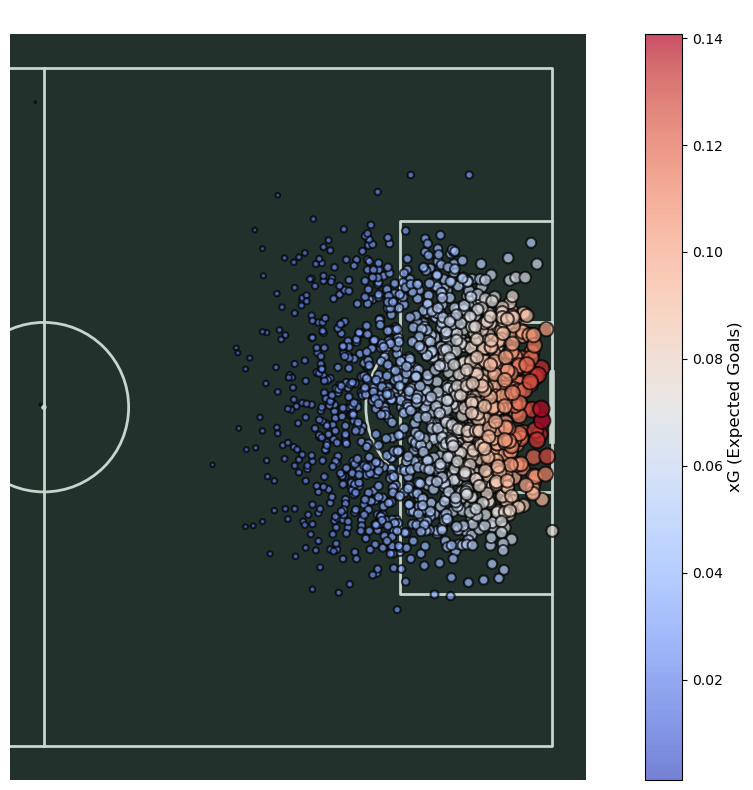

In [34]:
# Setup boiska
pitch = Pitch(pitch_type='statsbomb', half=True, pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

# Rysowanie strzałów
sc = pitch.scatter(
    df_shot.x, df_shot.y,
    s=df_shot.xG_model * 1000,  # Rozmiar punktu zależny od xG
    c=df_shot.xG_model,  # Kolor punktu wg wartości xG
    cmap='coolwarm',
    edgecolors=df_shot.goal.apply(lambda x: 'black' if x == 1 else 'none'),  # Obramowanie czarne dla goli
    linewidth=1.5,
    alpha=0.7,
    ax=ax
)

# Dodanie kolorowej belki
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('xG (Expected Goals)', fontsize=12)

plt.title('Mapa strzałów z uwzględnieniem xG', fontsize=14, color='white')
plt.show()


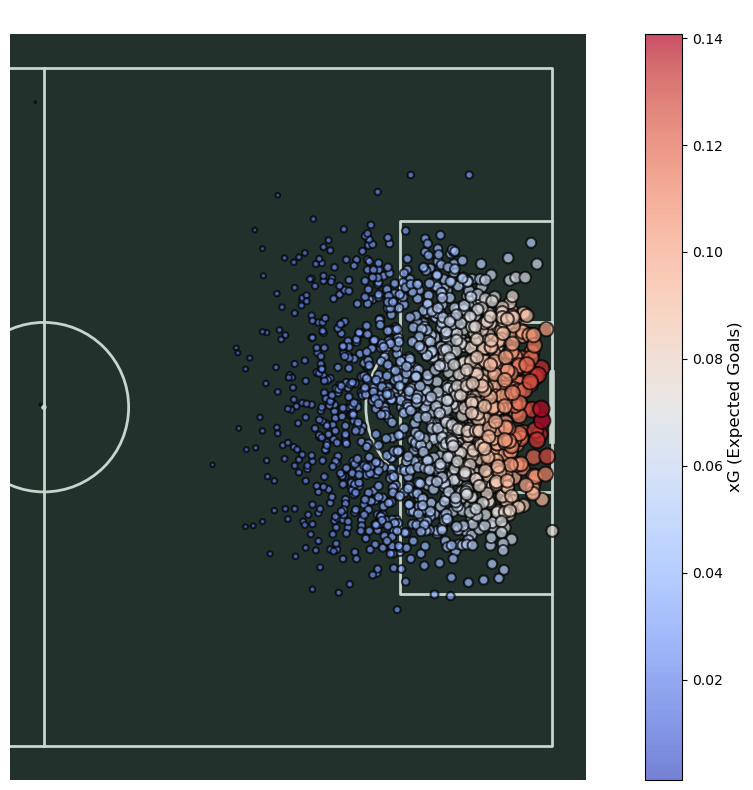

In [35]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Setup boiska
pitch = Pitch(pitch_type='statsbomb', half=True, pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

# Poprawne ustawienie obramowania
edgecolors = ['black' if goal == 1 else 'none' for goal in df_shot.goal]

# Rysowanie strzałów
sc = pitch.scatter(
    df_shot.x, df_shot.y,
    s=df_shot.xG_model * 1000,  # Rozmiar punktu zależny od xG
    c=df_shot.xG_model,  # Kolor punktu wg wartości xG
    cmap='coolwarm',
    edgecolors=edgecolors,  # Poprawione obramowanie
    linewidth=1.5,
    alpha=0.7,
    ax=ax
)

# Dodanie kolorowej belki
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('xG (Expected Goals)', fontsize=12)

plt.title('Mapa strzałów z uwzględnieniem xG', fontsize=14, color='white')
plt.show()


In [36]:
df_shot.columns

Index(['x', 'y', 'outcome_name', 'shot_statsbomb_xg', 'angle', 'distance',
       'goal', 'xG_model'],
      dtype='object')

In [37]:
df_shot[df_shot['goal'] == 1]

,x,y,outcome_name,shot_statsbomb_xg,angle,distance,goal,xG_model
7,107.5,50.6,Goal,0.069699,0.376939,14.135417,1,0.058516
10,108.3,38.6,Goal,0.063718,0.651077,11.700000,1,0.069239
12,106.2,31.8,Goal,0.159284,0.428496,14.424978,1,0.057451
14,114.4,36.9,Goal,0.726976,1.062315,5.600000,1,0.103921
16,107.2,41.2,Goal,0.153815,0.601240,12.800000,1,0.064286
...,...,...,...,...,...,...,...,...
1328,114.5,34.1,Goal,0.440301,0.731078,5.818935,1,0.101802
1330,109.9,50.3,Goal,0.096603,0.398150,11.903781,1,0.067952
1343,115.3,38.3,Goal,0.331067,1.336358,4.700000,1,0.110647
1347,100.5,55.8,Goal,0.027778,0.248850,22.792323,1,0.032352


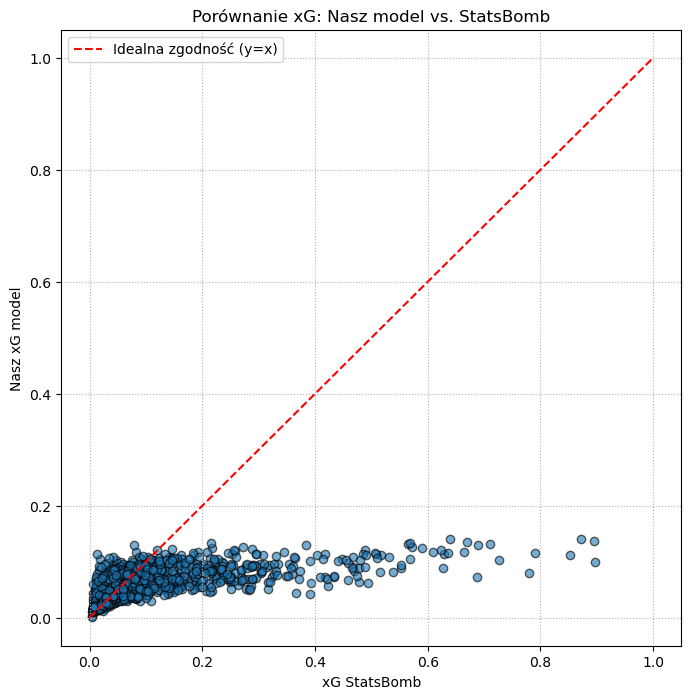

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Tworzymy wykres scatter
plt.figure(figsize=(8, 8))
plt.scatter(df_shot['shot_statsbomb_xg'], df_shot['xG_model'], alpha=0.6, edgecolors='k')

# Dodajemy linię idealnej zgodności y=x
x = np.linspace(0, 1, 100)
plt.plot(x, x, linestyle='dashed', color='red', label='Idealna zgodność (y=x)')

plt.xlabel("xG StatsBomb")
plt.ylabel("Nasz xG model")
plt.title("Porównanie xG: Nasz model vs. StatsBomb")
plt.legend()
plt.grid(True, linestyle='dotted')

plt.show()


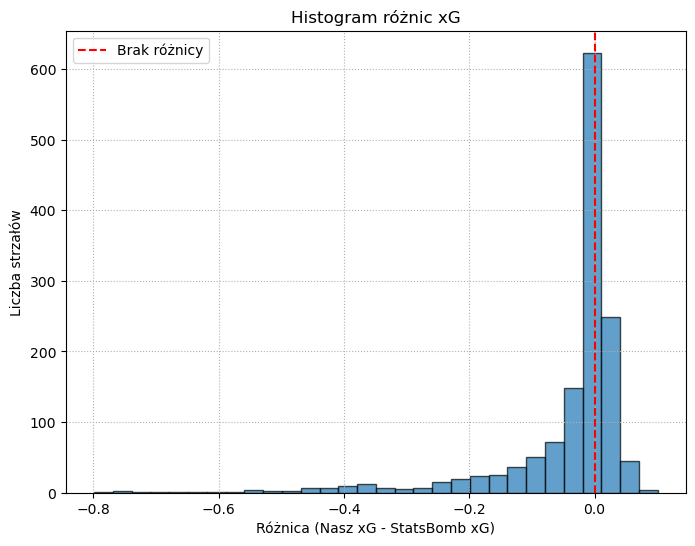

In [39]:
plt.figure(figsize=(8, 6))
plt.hist(df_shot['xG_model'] - df_shot['shot_statsbomb_xg'], bins=30, edgecolor='black', alpha=0.7)

plt.axvline(0, color='red', linestyle='dashed', label="Brak różnicy")
plt.xlabel("Różnica (Nasz xG - StatsBomb xG)")
plt.ylabel("Liczba strzałów")
plt.title("Histogram różnic xG")
plt.legend()
plt.grid(True, linestyle='dotted')

plt.show()


In [40]:
# Wyświetlenie listy meczów i drużyn
df_match[['match_id', 'home_team_name', 'away_team_name']]
df_match[df_match['home_team_name'] == 'Poland']

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_id,country_name,competition_name,season_id,season_name,home_team_id,home_team_name,home_team_gender,home_team_group,home_team_country_id,home_team_country_name,home_team_managers_id,home_team_managers_name,home_team_managers_nickname,home_team_managers_dob,home_team_managers_country_id,home_team_managers_country_name,away_team_id,away_team_name,away_team_gender,away_team_group,away_team_country_id,away_team_country_name,away_team_managers_id,away_team_managers_name,away_team_managers_nickname,away_team_managers_dob,away_team_managers_country_id,away_team_managers_country_name,metadata_data_version,metadata_shot_fidelity_version,metadata_xy_fidelity_version,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
11,3857264,2022-11-30,2022-11-30 21:00:00,0,2,available,available,2023-07-25 08:24:09.695404,2023-07-25 09:10:13.832053,3,43,International,FIFA World Cup,106,2022,789,Poland,male,C,182,Poland,5294,Czesław Michniewicz,Czesław Michniewicz,1970-02-12,182,Poland,779,Argentina,male,C,11,Argentina,5677,Lionel Sebastián Scaloni,Lionel Sebastián Scaloni,1978-05-16,11,Argentina,1.1.0,2,2,10,Group Stage,1001115,Stadium 974,185,Qatar,293.0,Danny Desmond Makkelie,160.0,Netherlands
40,3857297,2022-11-26,2022-11-26 15:00:00,2,0,available,available,2023-02-20 08:54:08.741754,2023-04-27 00:19:40.857571,2,43,International,FIFA World Cup,106,2022,789,Poland,male,C,182,Poland,5294,Czesław Michniewicz,Czesław Michniewicz,1970-02-12,182,Poland,799,Saudi Arabia,male,C,200,Saudi Arabia,642,Hervé Renard,Hervé Renard,1968-09-30,78,France,1.1.0,2,2,10,Group Stage,94425,Education City Stadium,185,Qatar,986.0,Wilton Pereira Sampaio,31.0,Brazil


In [41]:
match_id = 3857264    # Poland vs Argentina

In [42]:
def shots_data_frame(match_id, home_team_name=None, away_team_name=None):
    df_shot = pd.DataFrame(columns=['x', 'y', 'outcome_name', 'shot_statsbomb_xg'])
    team_check = True
    if home_team_name:
        team_check = (df_matches[match_id]['event'].team_name == home_team_name)
    if away_team_name:
        team_check = (df_matches[match_id]['event'].team_name == home_team_name)
    mask_shot = (df_matches[match_id]['event'].type_name == 'Shot') & (df_matches[match_id]['event'].period	<= 4) & (df_matches[match_id]['event'].sub_type_name == 'Open Play') & team_check
    shots_temp = df_matches[match_id]['event'].loc[mask_shot, ['x', 'y', 'outcome_name', 'shot_statsbomb_xg']]
    df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)
    
    return df_shot

In [43]:
df_pol = shots_data_frame(match_id, 'Poland')
df_arg = shots_data_frame(match_id, 'Argentina')

In [44]:
df_pol

,x,y,outcome_name,shot_statsbomb_xg
0,100.7,41.3,Blocked,0.061495
1,105.9,43.5,Wayward,0.065580
2,108.8,43.5,Off T,0.043813
3,101.1,56.9,Blocked,0.026707


In [45]:
# visualizing shots
def visualize_shots(df_shots):
    # filter goals / non-shot goals
    df_goals = df_shots[df_shots.outcome_name == 'Goal'].copy()
    df_non_goal_shots = df_shots[df_shots.outcome_name != 'Goal'].copy()
    
    # setup the pitch
    pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                          half=True,  # half of a pitch
                          goal_type='box',
                          goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency
    
    fig, ax = pitch.draw(figsize=(12, 10))
    
    sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                        c='#ba4f45',
                        marker='o',
                        ax=ax, label="No goal")
    
    sc2 = pitch.scatter(df_goals.x, df_goals.y,
                        c='#ad993c',
                        marker='o',
                        ax=ax, label="Goal")
    
    plt.legend(loc='best')
    plt.show()

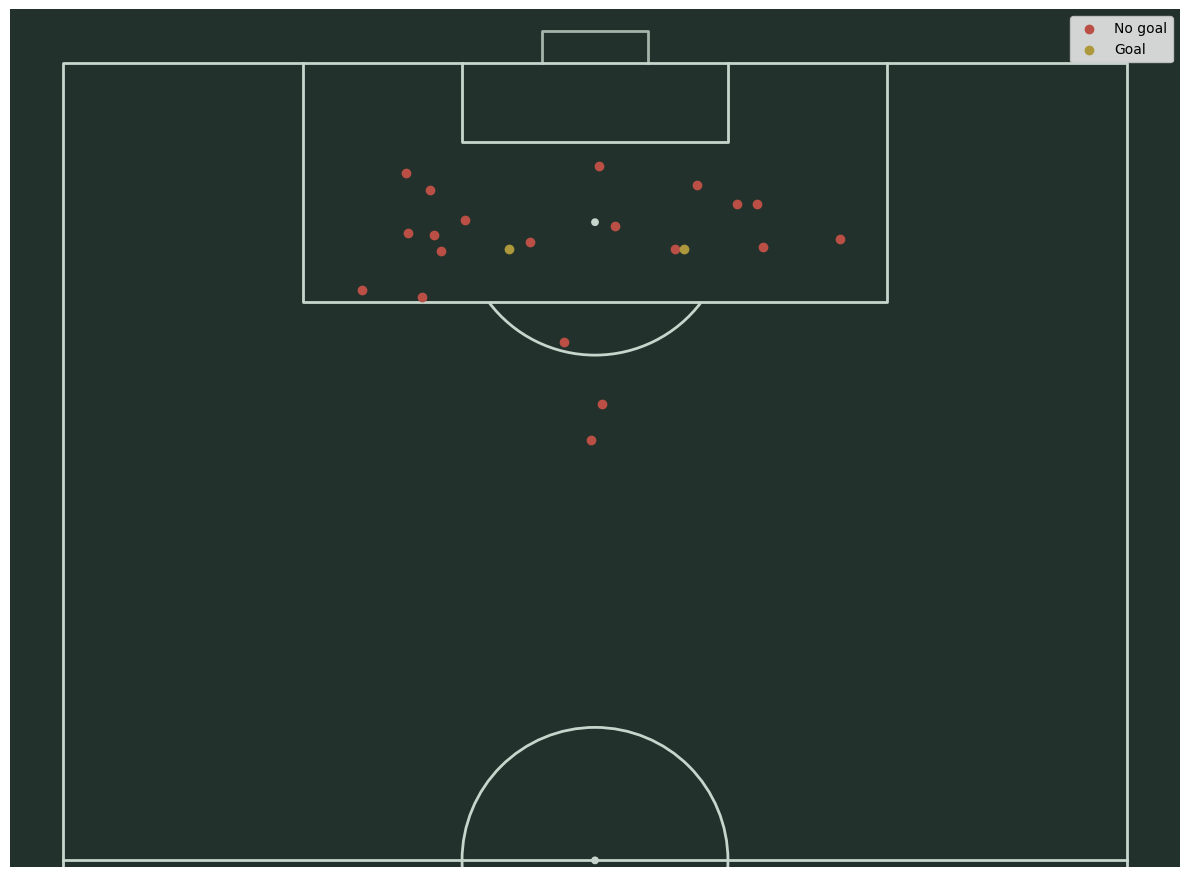

In [46]:
visualize_shots(df_arg)

In [47]:
df_arg['angle'] = df_arg.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_arg['distance'] = df_arg.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)
# we'll create new column to define goal or not
df_arg['goal'] = df_arg.apply(lambda row:1 if row['outcome_name']=='Goal' else 0, axis=1)

In [48]:
# Obliczamy xG według wytrenowanego modelu
df_arg['xG_model'] = df_arg.apply(
    lambda row: 1 / (1 + math.exp(-(intercept + coef_distance * row['distance'] + coef_angle * math.radians(row['angle'])))), 
    axis=1
)

# Porównujemy model z danymi StatsBomb
df_arg[['shot_statsbomb_xg', 'xG_model', 'goal']]

,shot_statsbomb_xg,xG_model,goal
0,0.050873,0.036697,0
1,0.034159,0.026489,0
2,0.053251,0.062350,0
3,0.051414,0.053996,0
4,0.149358,0.077693,0
5,0.024708,0.034660,0
6,0.024548,0.021939,0
7,0.190838,0.064102,0
8,0.037203,0.039867,0
9,0.315272,0.089985,0


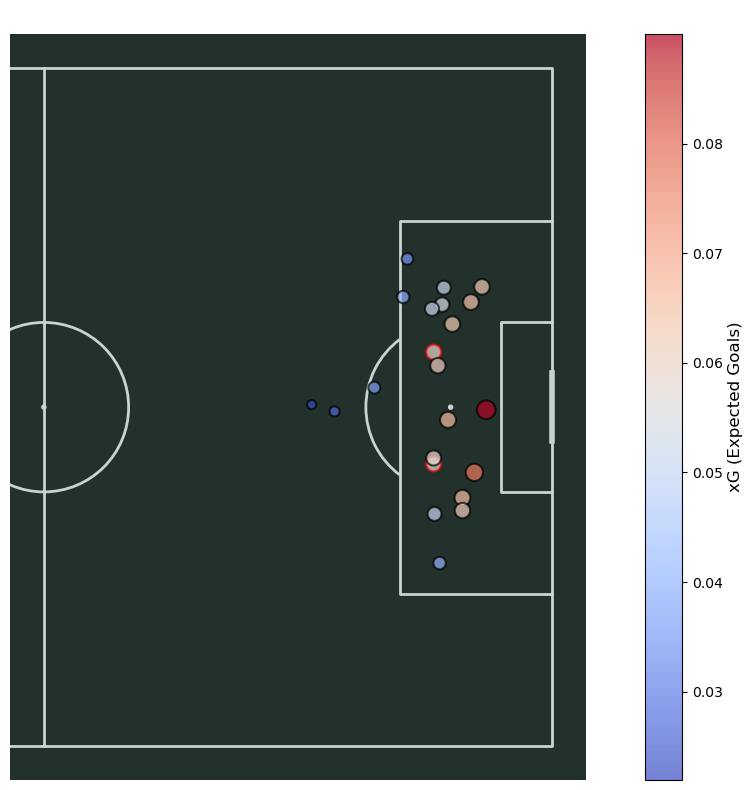

In [49]:
# Setup boiska
pitch = Pitch(pitch_type='statsbomb', half=True, pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

# Rysowanie strzałów
sc = pitch.scatter(
    df_arg.x, df_arg.y,
    s=df_arg.xG_model * 2000,  # Rozmiar punktu zależny od xG
    c=df_arg.xG_model,  # Kolor punktu wg wartości xG
    cmap='coolwarm',
    edgecolors=df_arg.goal.apply(lambda x: 'red' if x == 1 else 'black'),  # Obramowanie czarne dla goli
    linewidth=1.5,
    alpha=0.7,
    ax=ax
)

# Dodanie kolorowej belki
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('xG (Expected Goals)', fontsize=12)

plt.title('Mapa strzałów z uwzględnieniem xG', fontsize=14, color='white')
plt.show()